<a href="https://colab.research.google.com/github/GraceOby/Hamoye/blob/main/GOT_modelling1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("/content/drive/MyDrive/HAMOYE-Internship/project/datasets/cleaned_got_for_ml.csv")
df.head()

,Unnamed: 0,male,book1,book4,isAliveHeir,age,numDeadRelations,boolDeadRelations,isPopular,popularity,...,heir_Halleck Hoare,heir_Jaehaerys Targaryen,heir_Myrcella Baratheon,heir_Rhaegar Targaryen,heir_Rhaegel Targaryen,heir_Rhaenyra Targaryen,heir_Shireen Baratheon,heir_Theon Greyjoy,heir_Tommen Baratheon,heir_unknown
0,0,1,0,0,0.0,37.0,11,1,1,0.605351,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,-1.0,97.0,1,1,1,0.896321,...,0,0,0,0,0,0,0,0,0,1
2,2,1,0,1,-1.0,37.0,0,0,0,0.267559,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,-1.0,23.0,0,0,0,0.183946,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,1,-1.0,29.0,0,0,0,0.043478,...,0,0,0,0,0,0,0,0,0,1


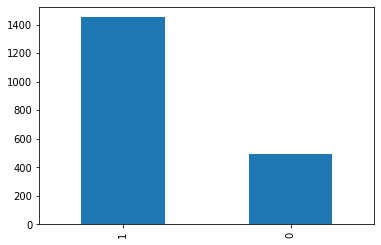

In [3]:
df.isAlive.value_counts().plot(kind="bar")

We have an imbalance of our target variable
1. We train our models without sampling
2. We resample and then train our models

**Some EDA**

In [5]:
df.shape 

(1946, 74)

In [6]:
df.columns

Index(['Unnamed: 0', 'male', 'book1', 'book4', 'isAliveHeir', 'age',
       'numDeadRelations', 'boolDeadRelations', 'isPopular', 'popularity',
       'isAlive', 'inHouseOfAllegnc', 'mother_Alicent Hightower',
       'mother_Alyssa Targaryen', 'mother_Alyssa Velaryon',
       'mother_Betha Blackwood', 'mother_Cassana Estermont',
       'mother_Catelyn Stark', 'mother_Cersei Lannister',
       'mother_Daenaera Velaryon', 'mother_Dyanna Dayne',
       'mother_Lady of House Sunderly', 'mother_Mariah Martell',
       'mother_Naerys Targaryen', 'mother_Rhaenyra Targaryen',
       'mother_Rhaenys Targaryen', 'mother_Shaera Targaryen',
       'mother_Valaena Velaryon', 'mother_Visenya Targaryen', 'mother_unknown',
       'father_Aegon I Targaryen', 'father_Aegon III Targaryen',
       'father_Aegon IV Targaryen', 'father_Aegon V Targaryen',
       'father_Aenys I Targaryen', 'father_Aerion Targaryen',
       'father_Baelon Targaryen', 'father_Brandon Stark',
       'father_Daemon Targaryen', 

In [8]:
pd.crosstab(df.male, df.isAlive)

isAlive,0,1
male,,
0,128,613
1,367,838


We have 128 dead women, 613 alive women

367 dead men and 838 alive men...

Generally (128/741) * 100 = 17% that is there is a 17% chance that a female record turns out dead

And (367/1205) * 100 = 30.5% chance that a male record turns out dead.



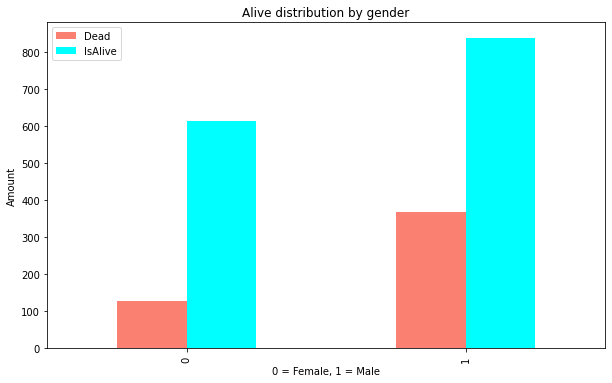

In [10]:
pd.crosstab(df.male, df.isAlive).plot(kind='bar', figsize=(10,6), color=["salmon", "cyan"])

plt.title("Alive distribution by gender")
plt.xlabel("0 = Female, 1 = Male")
plt.ylabel("Amount")
plt.legend(["Dead", "IsAlive"])

In [11]:
pd.crosstab(df.isPopular, df.isAlive)

isAlive,0,1
isPopular,,
0,435,1396
1,60,55


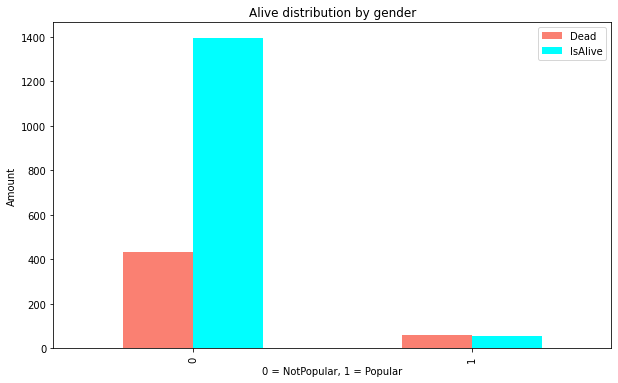

In [12]:
pd.crosstab(df.isPopular, df.isAlive).plot(kind='bar', figsize=(10,6), color=["salmon", "cyan"])

plt.title("Alive distribution by gender")
plt.xlabel("0 = NotPopular, 1 = Popular")
plt.ylabel("Amount")
plt.legend(["Dead", "IsAlive"])

I guess that makes watching GOT interesting!!!

Who cares when unknown men die in battle?

But when (60/115) * 100 = 55% of people you find interesting die, Thats something(lol)

In [13]:
corr = df.corr()
corr


,Unnamed: 0,male,book1,book4,isAliveHeir,age,numDeadRelations,boolDeadRelations,isPopular,popularity,...,heir_Halleck Hoare,heir_Jaehaerys Targaryen,heir_Myrcella Baratheon,heir_Rhaegar Targaryen,heir_Rhaegel Targaryen,heir_Rhaenyra Targaryen,heir_Shireen Baratheon,heir_Theon Greyjoy,heir_Tommen Baratheon,heir_unknown
Unnamed: 0,1.000000,0.117225,0.290130,0.284554,-0.110538,0.009581,0.092734,0.171157,0.170451,0.277761,...,-0.015358,-0.045992,-0.039052,-0.027306,-0.027387,-0.038971,-0.032311,0.027185,-0.037235,0.111802
male,0.117225,1.000000,0.084876,-0.063178,0.082368,0.038032,0.041736,0.053249,0.129207,0.140828,...,0.017781,0.025153,0.017781,0.017781,0.017781,0.017781,0.017781,0.017781,0.017781,-0.085761
book1,0.290130,0.084876,1.000000,0.079959,-0.052248,-0.005360,0.191853,0.241630,0.252426,0.324782,...,-0.011279,-0.015955,-0.011279,-0.011279,-0.011279,-0.011279,-0.011279,-0.011279,-0.011279,0.054401
book4,0.284554,-0.063178,0.079959,1.000000,-0.126519,-0.121877,-0.007731,0.036482,0.035127,0.116085,...,-0.027312,-0.038635,-0.027312,-0.027312,-0.027312,-0.027312,-0.027312,-0.027312,-0.027312,0.131732
isAliveHeir,-0.110538,0.082368,-0.052248,-0.126519,1.000000,0.000568,0.350384,0.275447,0.348785,0.376753,...,0.241551,0.341692,0.241551,0.119585,0.119585,0.241551,0.241551,0.241551,0.241551,-0.960431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heir_Rhaenyra Targaryen,-0.038971,0.017781,-0.011279,-0.027312,0.241551,0.000123,0.076932,0.079912,0.090476,0.083246,...,-0.000514,-0.000727,-0.000514,-0.000514,-0.000514,1.000000,-0.000514,-0.000514,-0.000514,-0.207332
heir_Shireen Baratheon,-0.032311,0.017781,-0.011279,-0.027312,0.241551,0.000123,0.060544,0.079912,0.090476,0.128597,...,-0.000514,-0.000727,-0.000514,-0.000514,-0.000514,-0.000514,1.000000,-0.000514,-0.000514,-0.207332
heir_Theon Greyjoy,0.027185,0.017781,-0.011279,-0.027312,0.241551,0.000123,0.060544,0.079912,0.090476,0.091749,...,-0.000514,-0.000727,-0.000514,-0.000514,-0.000514,-0.000514,-0.000514,1.000000,-0.000514,-0.207332
heir_Tommen Baratheon,-0.037235,0.017781,-0.011279,-0.027312,0.241551,0.000123,0.076932,0.079912,0.090476,0.128597,...,-0.000514,-0.000727,-0.000514,-0.000514,-0.000514,-0.000514,-0.000514,-0.000514,1.000000,-0.207332


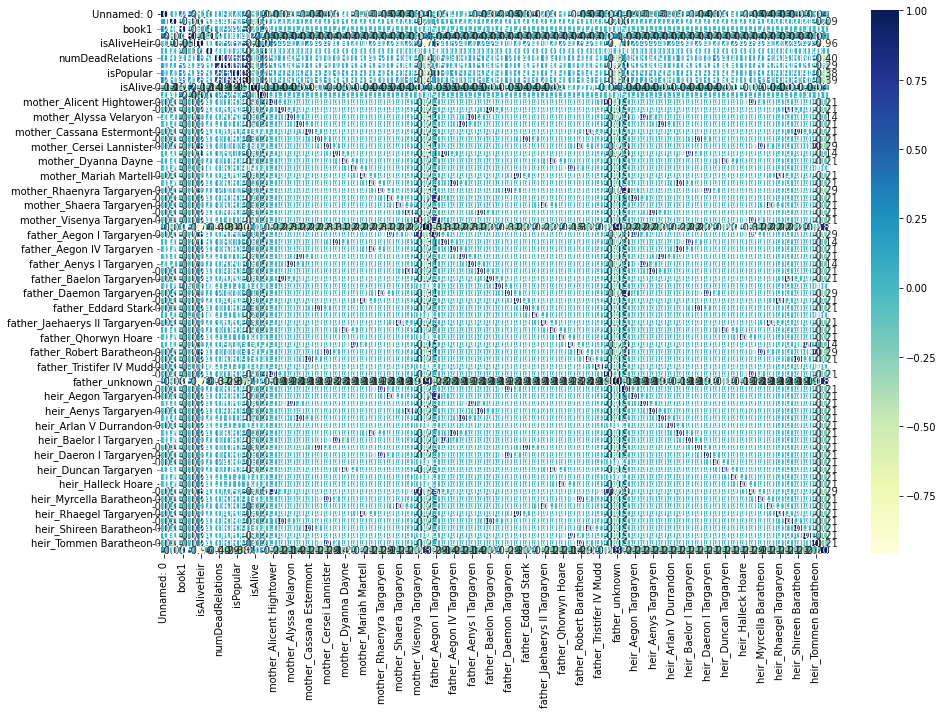

In [14]:
# Let's make it look a little prettier
plt.figure(figsize=(15, 10))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu")

**Modeling without Resampling**

In [17]:
df.head()

,Unnamed: 0,male,book1,book4,isAliveHeir,age,numDeadRelations,boolDeadRelations,isPopular,popularity,...,heir_Halleck Hoare,heir_Jaehaerys Targaryen,heir_Myrcella Baratheon,heir_Rhaegar Targaryen,heir_Rhaegel Targaryen,heir_Rhaenyra Targaryen,heir_Shireen Baratheon,heir_Theon Greyjoy,heir_Tommen Baratheon,heir_unknown
0,0,1,0,0,0.0,37.0,11,1,1,0.605351,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,-1.0,97.0,1,1,1,0.896321,...,0,0,0,0,0,0,0,0,0,1
2,2,1,0,1,-1.0,37.0,0,0,0,0.267559,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,-1.0,23.0,0,0,0,0.183946,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,1,-1.0,29.0,0,0,0,0.043478,...,0,0,0,0,0,0,0,0,0,1


In [18]:

X = df.drop("isAlive", axis=1)
y = df["isAlive"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


len(X_train), len(X_test)

(1556, 390)

**MODEL CHOICES**

Now we've got our data prepared, we can start to fit models. We'll be using the following and comparing their results.

* Logistic Regression - LogisticRegression()
* K-Nearest Neighbors - KNeighboursClassifier()
* RandomForest - RandomForestClassifier()

In [19]:

# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [20]:

model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores


{'KNN': 0.6974358974358974,
 'Logistic Regression': 0.8076923076923077,
 'Random Forest': 0.7769230769230769}

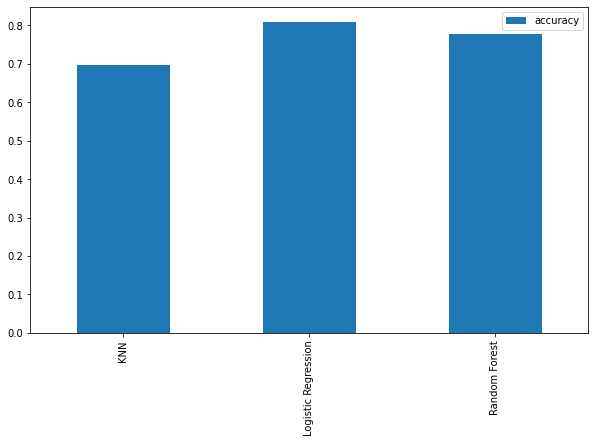

In [21]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot(kind='bar', figsize=(10,6))


**Tunning Hyperparameters**

**KNN**

The basic parameter to tune in K Neighbors Classifier is the n_neighors

Since we will be tunning just one parameter here, we tune by hand

In [22]:
# Create a list of train scores
train_scores = []

# Create a list of test scores
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21) # 1 to 20

# Setup algorithm
knn = KNeighborsClassifier()

# Loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i) # set neighbors value
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores
    test_scores.append(knn.score(X_test, y_test))

In [23]:
test_scores


[0.6717948717948717,
 0.5692307692307692,
 0.6846153846153846,
 0.6358974358974359,
 0.6974358974358974,
 0.6641025641025641,
 0.7153846153846154,
 0.6948717948717948,
 0.7307692307692307,
 0.7230769230769231,
 0.7384615384615385,
 0.7205128205128205,
 0.7384615384615385,
 0.735897435897436,
 0.7487179487179487,
 0.7461538461538462,
 0.7410256410256411,
 0.7384615384615385,
 0.7512820512820513,
 0.7435897435897436]

Maximum KNN score on the test data: 75.13%


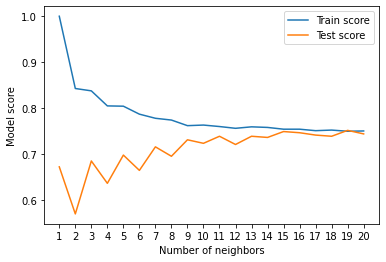

In [24]:

#Let's plot to have a better view

plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

The best score on the test data using **Knn is 75.13% at 19-neighbors...**

Let's see how other models will perform...

Tunning our *RandomForestClassifier model* and *LogisticRegression model* with

**RandonizedSearchCv**

In [25]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

RandomizedSearch for Logistic Regression

In [26]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [27]:
rs_log_reg.best_params_


{'solver': 'liblinear', 'C': 1438.44988828766}

In [28]:
rs_log_reg.score(X_test, y_test)

0.8153846153846154

From 0.81% to 0.82%... Not much difference

In [29]:
#RandomizedSearch for Random Forest Classifier

In [30]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [31]:

# Find the best parameters
rs_rf.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [32]:

# Evaluate the randomized search random forest model
rs_rf.score(X_test, y_test)


0.8102564102564103

So far the Logistic Regression is taking the lead but by a slight difference with RandForest Classifier

We further tune it exhaustively over various other parameters using GridSearchCV




In [34]:

log_reg_grid = {"penalty":["l1", "l2"],
                "C":np.logspace(-4,4,20),
                "solver":["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

In [35]:
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [36]:

gs_log_reg.best_params_


{'C': 1438.44988828766, 'penalty': 'l2', 'solver': 'liblinear'}

In [37]:
gs_log_reg.score(X_test, y_test)

0.8153846153846154

Still same, but worth the try.

That concludes out parameter tunning

**Other Evaluation**

1. ROC/AUC

2. Classification Report

3. Confusion metrics

4. Cross_val_score

**ROC curve and AUC scores.**

It's a way of understanding how your model is performing by comparing the true positive rate to the false positive rate.

In our case...

To get an appropriate example in a real-world problem, consider a diagnostic test that seeks to determine whether a person has a certain disease. A false positive in this case occurs when the person tests positive, but does not actually have the disease.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


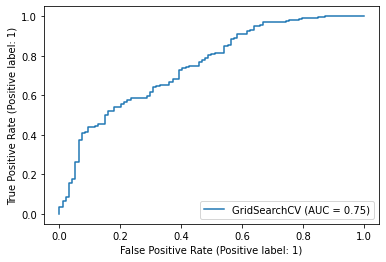

In [38]:

plot_roc_curve(gs_log_reg, X_test, y_test)

Great!

Our model predits with 25% confusion that a person isAlive when actually is Dead

Is this negligible since it predicts with 75% accuracy?

There is still room for improvement

**Confusion Matrix**

In [40]:

#The confusion matrix will need predictions from our model

y_preds = gs_log_reg.predict(X_test)
y_preds

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [41]:
y_test

1611    0
1403    1
974     0
1055    1
307     1
       ..
618     0
426     1
966     1
849     1
1740    0
Name: isAlive, Length: 390, dtype: int64

In [42]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[ 31  63]
 [  9 287]]


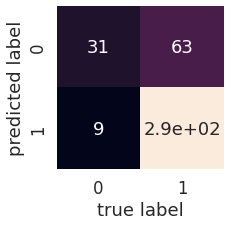

In [43]:
sns.set(font_scale=1.5) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds)

There are 63 occasions where our model predicted a character dead when they were actually alive and...

And 9 occasion where our model predicted a character Alive when they had died...

**See any impact of imbalnce?**

**Classification Report**

In [44]:
# Show classification report
print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       0.78      0.33      0.46        94
           1       0.82      0.97      0.89       296

    accuracy                           0.82       390
   macro avg       0.80      0.65      0.68       390
weighted avg       0.81      0.82      0.79       390



Cross_val_score

In [45]:
# Check best hyperparameters
gs_log_reg.best_params_


{'C': 1438.44988828766, 'penalty': 'l2', 'solver': 'liblinear'}

In [46]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

# Instantiate best model with best hyperparameters (found with GridSearchCV)
clf = LogisticRegression(C=0.23357214690901212,
                         solver="liblinear")

In [47]:

# Cross-validated accuracy score
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc



array([0.78205128, 0.76863753, 0.76863753, 0.8251928 , 0.61696658])

In [48]:

cv_acc = np.mean(cv_acc)
cv_acc



0.7522971458704106

In [49]:
# Cross-validated precision score
cv_precision = np.mean(cross_val_score(clf,
                                       X,
                                       y,
                                       cv=5, # 5-fold cross-validation
                                       scoring="precision")) # precision as scoring
cv_precision


0.804752604400098

In [50]:
# Cross-validated recall score
cv_recall = np.mean(cross_val_score(clf,
                                    X,
                                    y,
                                    cv=5, # 5-fold cross-validation
                                    scoring="recall")) # recall as scoring
cv_recall


0.8979381443298969

In [51]:

# Cross-validated F1 score
cv_f1 = np.mean(cross_val_score(clf,
                                X,
                                y,
                                cv=5, # 5-fold cross-validation
                                scoring="f1")) # f1 as scoring
cv_f1

0.8354491502635832

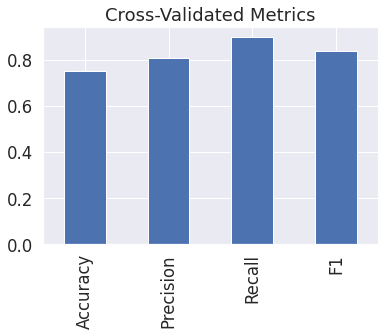

In [52]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

* Accuracy - The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0
* Precision - Indicates the proportion of positive identifications (model predicted class 1) which were actually correct.
* Recall - Indicates the proportion of actual positives which were correctly classified.
* F1 score - A combination of precision and recall. A perfect model achieves an F1 score of 1.0.

**Feature importance**

Feature importance is another way of asking, "which features contributing most to the outcomes of the model?"

> For our problem, trying to predict whether a character is Alive or not, which features/characteristics contribute most to model prediction

In [53]:
# Fit an instance of LogisticRegression (taken from above)
clf.fit(X_train, y_train);

In [54]:

# Check coef_
clf.coef_

array([[-7.42700773e-04, -4.66615081e-01, -5.43119833e-01,
         1.52061782e+00, -1.53113355e-01, -1.52067054e-02,
        -1.26775070e-01, -4.55747279e-01,  2.86187481e-01,
        -1.33808661e-01, -2.33796782e-01, -2.34980963e-02,
        -3.60201420e-02, -8.63661682e-02,  0.00000000e+00,
         1.68864380e-01, -2.69836531e-02,  1.29896267e-01,
        -1.76963191e-02, -1.23656164e-02,  1.46497347e-01,
        -4.43089019e-02,  0.00000000e+00, -4.80001462e-02,
         0.00000000e+00, -2.06096940e-02, -2.69916631e-02,
        -7.41908670e-02,  5.79478327e-01, -7.41908670e-02,
        -1.76963191e-02,  0.00000000e+00,  0.00000000e+00,
        -8.63661682e-02, -2.69916631e-02, -3.60201420e-02,
         1.08732186e-01, -4.80001462e-02, -4.43089019e-02,
        -2.69836531e-02, -8.45922635e-02, -2.06096940e-02,
        -1.23656164e-02,  1.30839786e-01,  1.21836391e-01,
         1.29896267e-01,  1.68864380e-01,  7.49201856e-02,
        -2.34980963e-02,  3.74239389e-01, -2.20563675e-0

In [55]:
# Match features to columns
features_dict = dict(zip(df.columns, list(clf.coef_[0])))
features_dict

{'Unnamed: 0': -0.000742700772914511,
 'male': -0.46661508055784,
 'book1': -0.5431198330244557,
 'book4': 1.520617824405793,
 'isAliveHeir': -0.15311335528084014,
 'age': -0.015206705361969334,
 'numDeadRelations': -0.1267750704866382,
 'boolDeadRelations': -0.4557472794820298,
 'isPopular': 0.28618748128386695,
 'popularity': -0.1338086606947099,
 'isAlive': -0.23379678187324368,
 'inHouseOfAllegnc': -0.023498096338137188,
 'mother_Alicent Hightower': -0.03602014200249047,
 'mother_Alyssa Targaryen': -0.08636616822908273,
 'mother_Alyssa Velaryon': 0.0,
 'mother_Betha Blackwood': 0.1688643801049756,
 'mother_Cassana Estermont': -0.026983653050497918,
 'mother_Catelyn Stark': 0.12989626681888114,
 'mother_Cersei Lannister': -0.01769631913035202,
 'mother_Daenaera Velaryon': -0.012365616362282214,
 'mother_Dyanna Dayne': 0.14649734701114733,
 'mother_Lady of House Sunderly': -0.04430890188588301,
 'mother_Mariah Martell': 0.0,
 'mother_Naerys Targaryen': -0.0480001461656766,
 'mother_R

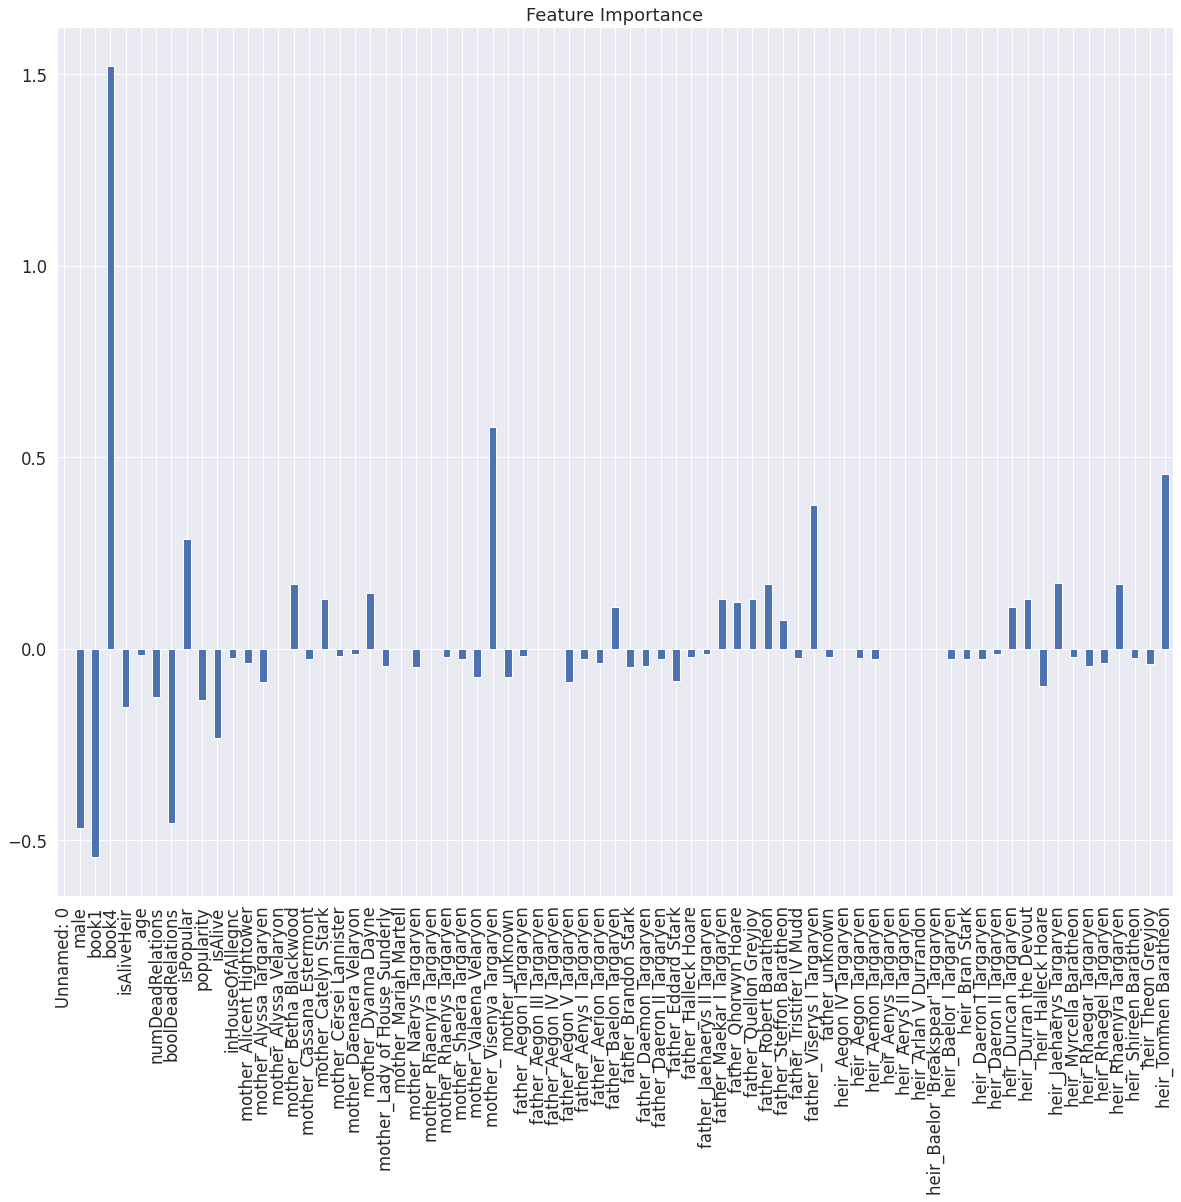

In [57]:

# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(20,16));

**NEXT STEPS**

> DataSet should be resampled: ie a balanced no of the target value should be used as threshold, (Data set should be drawn for say a 50:50 balance in the target variable, all others should be dropped)

> Coulmns, features that does not contribute majorly(both negatively or positively) as seen above to our model should be dropped and model retrained.